In [1]:
import sys
sys.path.append("..")
from library import *

In [20]:
def get_ry_mat(angle):
    return np.array([np.cos(angle/2), -np.sin(angle/2), np.sin(angle/2), np.cos(angle/2)]).reshape(2, 2)

def get_ryry_mat(theta, alpha):
    return np.kron(get_ry_mat(theta), get_ry_mat(alpha))

def get_circuit(psi0):
    M = 4
    tau = 3.5
    h2qc = H2QCircuit(m=M, tau=tau, trot_reps=10, psi0=psi0)
    return h2qc

def get_image_data(thetas, alphas):
    M = 4
    tau = 3.5
    
    ham = H2QCircuit.get_hamilt_op(n=2, radius=0.45).to_matrix()
    _, gs_state = get_ground_eigh(ham)
    
    data = np.zeros(shape=(len(thetas), len(alphas)))
    data2 = np.zeros(shape=(len(thetas), len(alphas)))
    for i, theta in enumerate(thetas):
        for j, alpha in enumerate(alphas):
            mat = get_ryry_mat(theta, alpha)
            psi0 = mat[:, 0] # equivalent to: mat @ np.array([1, 0, 0, 0])
            h2qc = H2QCircuit(m=M, tau=tau, trot_reps=10, psi0=psi0)
            h2qc.run_simulation(num_shots=1)
            
            qc_state = h2qc.final_state
            qc_state = normalize(qc_state[::2 ** (M * 2)])
            
            data[len(thetas) - i - 1, j] = get_fidelity(gs_state, qc_state)
            data2[len(thetas) - i - 1, j] = get_fidelity(qc_state, gs_state)
            
        print(f"{i+1}/{len(thetas)}")
            
    return data, data2

def get_image_data2(thetas, alphas):
    M = 4
    tau = 3.5
    
    ham = H2QCircuit.get_hamilt_op(n=2, radius=0.45).to_matrix()
    _, gs_state = get_ground_eigh(ham)
    ops = get_trotter_S(ham, tau=tau, m=M)
    
    data = np.zeros(shape=(len(thetas), len(alphas)))
    for i, theta in enumerate(thetas):
        for j, alpha in enumerate(alphas):
            mat = get_ryry_mat(theta, alpha)
            psi0 = mat[:, 0] # equivalent to: mat @ np.array([1, 0, 0, 0])
            
            qc_state = normalize(ops @ psi0)
            
            data[len(thetas) - i - 1, j] = get_fidelity(gs_state, qc_state)
            
        if i % 10 == 0:
            print(f"{i+1}/{len(thetas)}")
            
    return data

In [21]:
thetas = np.linspace(0, np.pi, 500)
alphas = np.linspace(0, np.pi, 500)

data = get_image_data2(thetas=thetas, alphas=alphas)

1/500
11/500
21/500
31/500
41/500
51/500
61/500
71/500
81/500
91/500
101/500
111/500
121/500
131/500
141/500
151/500
161/500
171/500
181/500
191/500
201/500
211/500
221/500
231/500
241/500
251/500
261/500
271/500
281/500
291/500
301/500
311/500
321/500
331/500
341/500
351/500
361/500
371/500
381/500
391/500
401/500
411/500
421/500
431/500
441/500
451/500
461/500
471/500
481/500
491/500


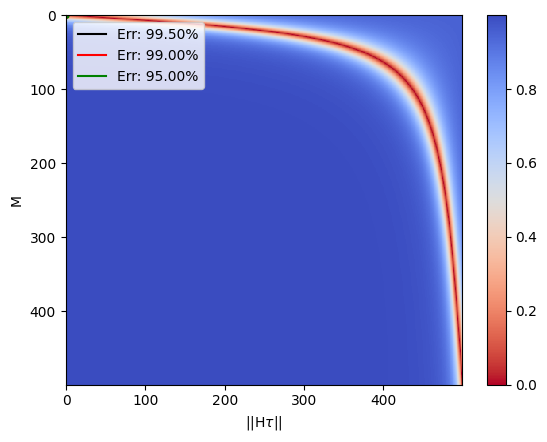

In [39]:
fig, ax = plt.subplots()
im = ax.imshow(data, interpolation='nearest', aspect="auto", cmap='coolwarm_r')
cbar = fig.colorbar(im, ax=ax)

thresholds = [0.995, 0.99, 0.95]
colors = ["black", "red", "green"]

for i, th in enumerate(thresholds):
    indexes = np.argmax(data < th, axis=1)
    mask = indexes == 0
    indexes = np.delete(indexes, mask)
    plt.plot(thetas[indexes], alphas[::-1][~mask], color=colors[i], label=f"Err: {th*100:.2f}%")

plt.xlabel(r"||H$\tau$||")
plt.ylabel("M")
plt.legend(loc="upper left")
# plt.title("Error between imaginary-time operator\n and circuit-simulated operator on a random H");
